In [1]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
img_array = cv2.imread("Dataset/mask/00000_Mask.jpg")

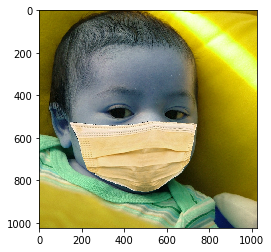

In [3]:
plt.imshow(img_array)

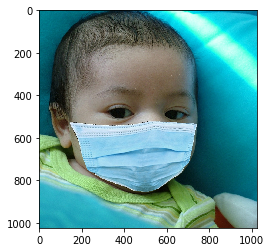

In [4]:
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))

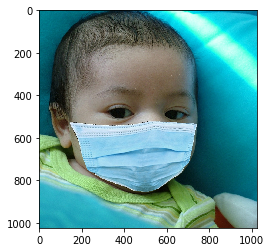

In [5]:
Datadirectory = "Dataset/"  ##training dataset
Classes = ["mask","no_mask"]  ##list of classes

for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        #backtorgb = cv2.Color(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break


# RESIZING

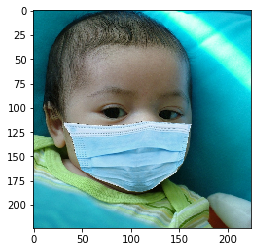

In [6]:
img_size = 224  ## ImageNet => 224 x 224

new_array = cv2.resize(img_array, (img_size,img_size))
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()


# READING THE IMAGES AND CONVERTING TO ARRAY



In [7]:
training_Data = []  ## data

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)  ## 0 1 => labels
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_Data.append([new_array,class_num])
            except Exception as e:
                pass

In [8]:
create_training_Data()

In [9]:
print(len(training_Data))

1950


In [10]:
import random

random.shuffle(training_Data)

In [11]:
x = []  ## data / feature
y = []  ## label

for features,label in training_Data:
    x.append(features)
    y.append(label)
    
x = np.array(x).reshape(-1, img_size, img_size, 3)

In [12]:
x.shape

(1950, 224, 224, 3)

In [13]:
x = x/255.0; ## normalizing the data

In [14]:
y = np.array(y)

In [15]:
import pickle

pickle_out = open("x.pickle","wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [16]:
pickle_in = open("x.pickle","rb")
x = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)


# DEEP LEARNING MODEL - TRANSFER LEARNING

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [18]:
model = tf.keras.applications.mobilenet.MobileNet()  ## pre-trained model

W1205 16:13:30.112993  1616 deprecation.py:506] From C:\Users\abhij\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

# TRANSFER LEARNING - Tuning, weights will start from last checkpoint

In [20]:
base_input = model.layers[0].input

In [21]:
base_output = model.layers[-4].output

In [22]:
## adding three more layers
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) ## 0,1
final_ouput = layers.Activation('sigmoid')(final_output)

In [23]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [24]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

# SETTINGS FOR BINARY CLASSIFICATION (FACE MASK / WITHOUT MASK)

In [25]:
new_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [26]:
new_model.fit(x,y, epochs = 1, validation_split = 0.1)

W1205 16:13:36.081342  1616 deprecation.py:323] From C:\Users\abhij\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1755 samples, validate on 195 samples
1755/1755 [==============================] - 476s 271ms/sample - loss: 0.1874 - acc: 0.9812 - val_loss: 0.0000e+00 - val_acc: 1.0000


In [27]:
new_model.save('my_model3.h5')

In [28]:
new_model = tf.keras.models.load_model('my_model.h5')

W1205 16:21:42.995273  1616 deprecation.py:506] From C:\Users\abhij\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1205 16:21:43.005246  1616 deprecation.py:506] From C:\Users\abhij\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1205 16:21:43.012229  1616 deprecation.py:506] From C:\Users\abhij\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be rem

# Checking the Network for Predictions

In [29]:
frame = cv2.imread('00002_Mask.jpg')

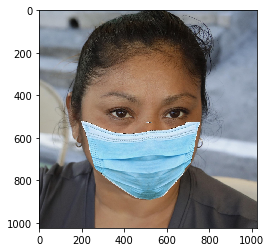

In [30]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [31]:
final_image = cv2.resize(frame, (224,224))
final_image = np.expand_dims(final_image, axis = 0) ## fourth dimension
final_image = final_image/255.0

In [32]:
Predictions = new_model.predict(final_image)

In [33]:
Predictions

array([[-34.870148]], dtype=float32)

# Checking the Network for Unknown Image

In [34]:
frame = cv2.imread('unknown.jpg')

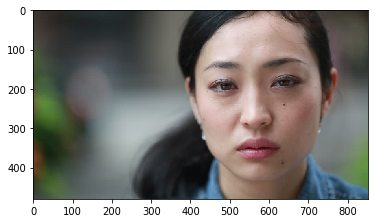

In [35]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [36]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [37]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [38]:
gray.shape

(480, 852)

In [41]:
faces = faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = frame[y:y+h, x:x+w]
    cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 0, 0), 2)
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not dectected")
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey: ey+eh, ex:ex +ew]

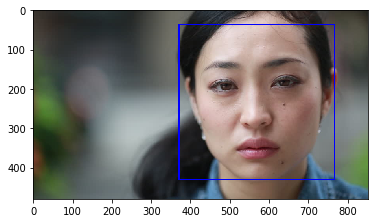

In [42]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

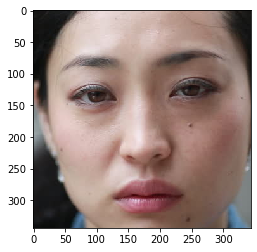

In [43]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [44]:
final_image = cv2.resize(face_roi, (224,224))
final_image = np.expand_dims(final_image, axis = 0) ## fourth dimension
final_image = final_image/255.0

In [45]:
Predictions = new_model.predict(final_image)

In [46]:
Predictions

array([[25.422693]], dtype=float32)

# REAL TIME

### Face Mask Detection

In [47]:
import cv2

In [60]:
path = "haarcascade_frontalface_default.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

# setting the rectangle background to white
rectangle_bgr = (255, 255, 255)

img = np.zeros((500,500))

text = "some text"

# getting the width and height of the text box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness = 1)[0]

# text starting position
text_offset_x = 10
text_offset_y = img.shape[0] - 25

# make the coordinates of the box with a padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height -2))
cv2. rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale = font_scale, color = (0, 0, 0), thickness = 1)


cap = cv2.VideoCapture(1)

# check if webcam is working properly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open WebCam")
    

while True:
    ret, frame = cap.read()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face not detected")
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex:ex +ew]
                

    final_image = cv2.resize(face_roi, (224,224))
    final_image = np.expand_dims(final_image, axis = 0) ## fourth dimension
    final_image = final_image/255.0

    font = cv2.FONT_HERSHEY_SIMPLEX

    Predictions = new_model.predict(final_image)

    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN

    if(Predictions > 0):
        status = "No Mask"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)


        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))

    else:
        status = "Face Mask"

        x1,y1,w1,h1 = 0,0,175,75
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)


        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))
    

    cv2.imshow('Face Mask Detection Model', frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
        

cap.release()
cv2.destroyAllWindow()

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d

KeyboardInterrupt: 